In [1]:
#!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 10.9 MB/s 
     |████████████████████████████████| 9.9 MB 28.6 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


# Importing Necessary Libraries

In [3]:
import numpy as np
import pandas as pd
import scipy.stats as sp
import seaborn as sns

import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

from sklearn.linear_model import LinearRegression as lm
import statsmodels.api as sm

Defining the functions

In [4]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return (diff)

In [5]:
def runMyAR1(yin):
    tlen = len(yin)
    y = np.array(yin[2:tlen])
    x = np.array(yin[1:(tlen-1)])
    X = x
    X = sm.add_constant(X)
    regr2 = sm.OLS(y,X)
    model = regr2.fit()
    print(model.summary())
    ypred = model.predict()
    plt.plot((y-ypred))

In [6]:
# Create large images!
register_matplotlib_converters()
sns.set_style("darkgrid")
plt.rc("figure", figsize=(14, 8)) # was 16,12
plt.rc("font", size=13)

Importing Data

In [7]:
df=pd.read_csv('/content/drive/MyDrive/DS Aegis/Time Series Adv Stats/All 3 models on datasets/Ren Gen TX.csv')

In [8]:
df.head()

,Unnamed: 0,"Renewable energy production, Texas (Billion Btu)"
0,1960,50155
1,1961,52023
2,1962,47721
3,1963,42718
4,1964,43884


In [10]:
df.rename(columns={'Year-Month':'Year','Renewable energy production, Texas (Billion Btu)':'BTU'}, inplace=True)
df.head()

,Year,BTU
0,1960,50155
1,1961,52023
2,1962,47721
3,1963,42718
4,1964,43884


lets see the original dataset then we will split into train and test

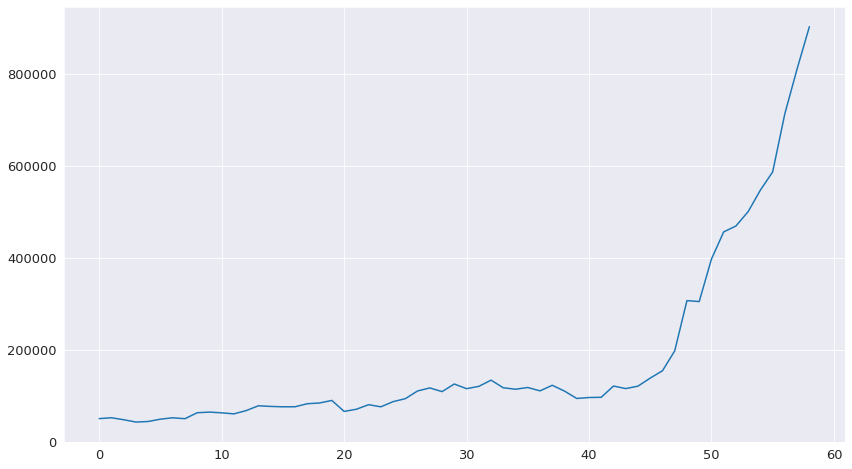

In [11]:
plt.plot(df['BTU'])



```
# This is formatted as code
```

----------------------------------------------------------------------------
- We can see upward trend in the dataset and in the later part its incresing exponentially
- Variance is also significant
- Seasonality is not so visible but lets decide after decompose
----------------------------------------------------------------------------

Splitting the dataset into train and test

In [12]:
df.shape

(59, 2)

In [13]:
df=df['BTU']

In [23]:
n=int(df.shape[0]*0.9) #test size=10% data
train=df.iloc[:n]
test=df.iloc[n:]


In [24]:
train.shape

(53,)

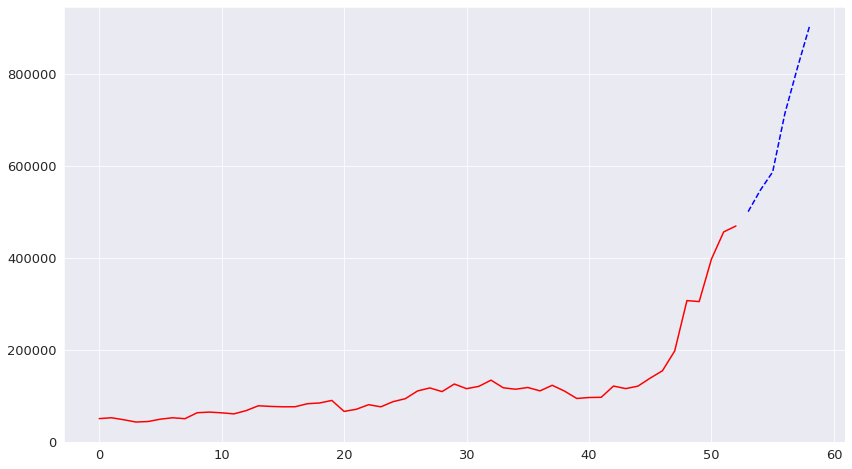

In [25]:
plt.plot(train,'r')
plt.plot(test,'b--')

Lets perform ADF test of stationarity on the train data

**Adfuller**


- **Null hypothesis**: Non Stationarity exists in the series.

- **Alternative Hypothesis**: Stationarity exists in the series

In [26]:
from statsmodels.tsa.stattools import adfuller

In [27]:
def dicky_fuller_test(df):
    result = adfuller(df)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[1]>0.05:
        print("Fail to reject the null hypothesis (H0), the data is non-stationary")
    else:
        print("Reject the null hypothesis (H0), the data is stationary.")

In [28]:
dicky_fuller_test(df)

ADF Statistic: 8.214153
p-value: 1.000000
Critical Values:
	1%: -3.548
	5%: -2.913
	10%: -2.594
Fail to reject the null hypothesis (H0), the data is non-stationary


In [29]:
dicky_fuller_test(train)

ADF Statistic: 0.989375
p-value: 0.994153
Critical Values:
	1%: -3.593
	5%: -2.932
	10%: -2.604
Fail to reject the null hypothesis (H0), the data is non-stationary


- We can conclude that the data is non stationary as p- value is significantly greater than 0.05. 
- It means our initial observation was corrent that the data has varing mean and variance with time 

In [ ]:
# lets decompose our Time series into its components

In [32]:
from statsmodels.tsa.seasonal import STL
stl = STL(train, period=10)

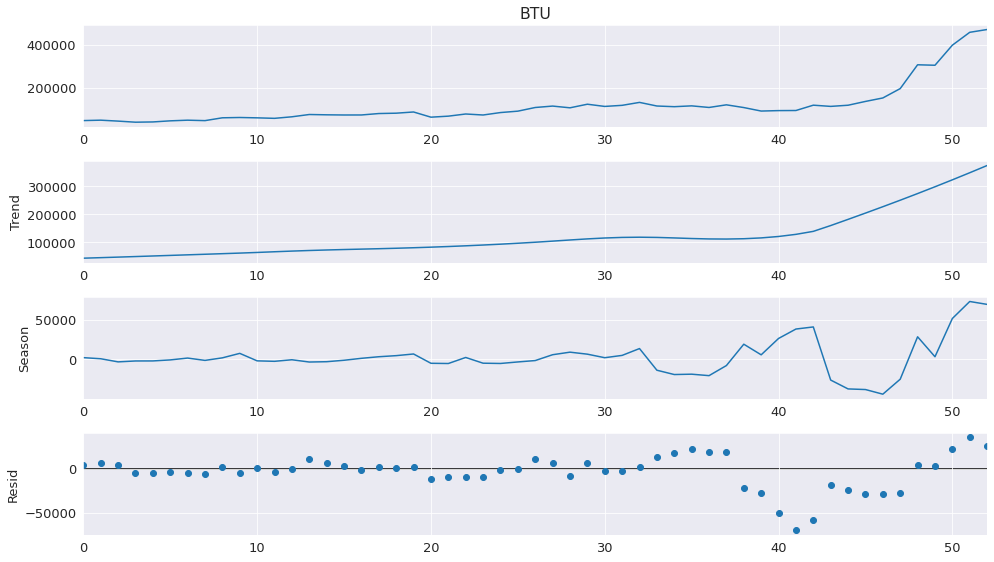

In [33]:
res = stl.fit()
fig = res.plot()

- There is gradual increase in trend
- Seasonality is absent so our initial observation was correct
- residuals are also random

lets transform the data by differencing method to get rid of trend

In [34]:
df_diff1 = difference(train, interval=1)

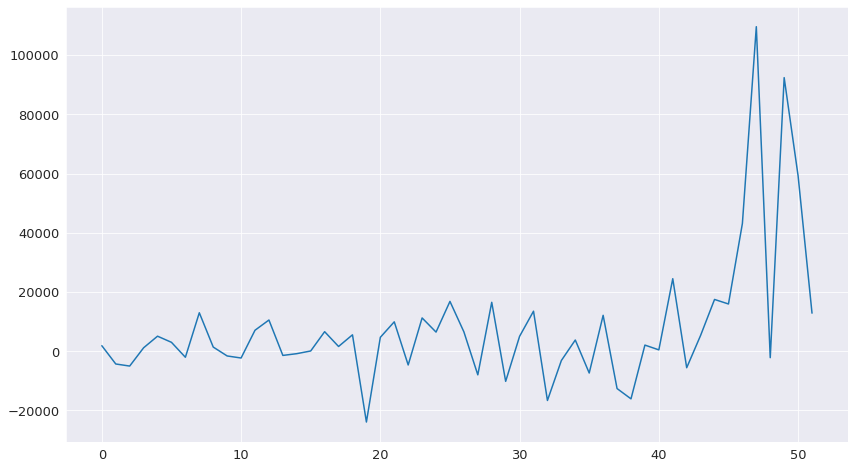

In [35]:
plt.plot(df_diff1)

In [36]:
# lets check wheather our data has now become stationary or not using ADF test
dicky_fuller_test(df_diff1)

ADF Statistic: -1.743802
p-value: 0.408698
Critical Values:
	1%: -3.593
	5%: -2.932
	10%: -2.604
Fail to reject the null hypothesis (H0), the data is non-stationary


In [37]:
df_diff2 = difference(df_diff1, interval=1)

In [38]:
dicky_fuller_test(df_diff2) # d=2

ADF Statistic: -11.079198
p-value: 0.000000
Critical Values:
	1%: -3.571
	5%: -2.923
	10%: -2.599
Reject the null hypothesis (H0), the data is stationary.


-----------------------------------------------------------------------------
Since, the data is now stationary, we will plot ACF-PACF plots to get the neccessary parameters of ARIMA model


**ACF-PACF Plots**

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


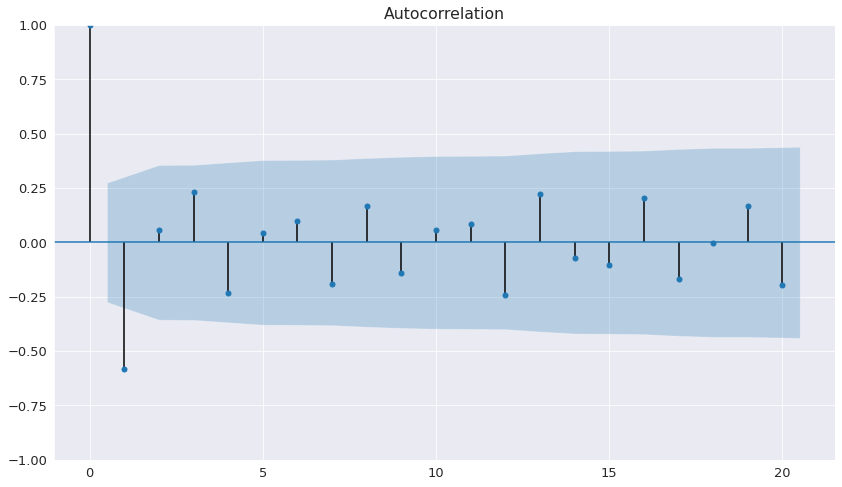

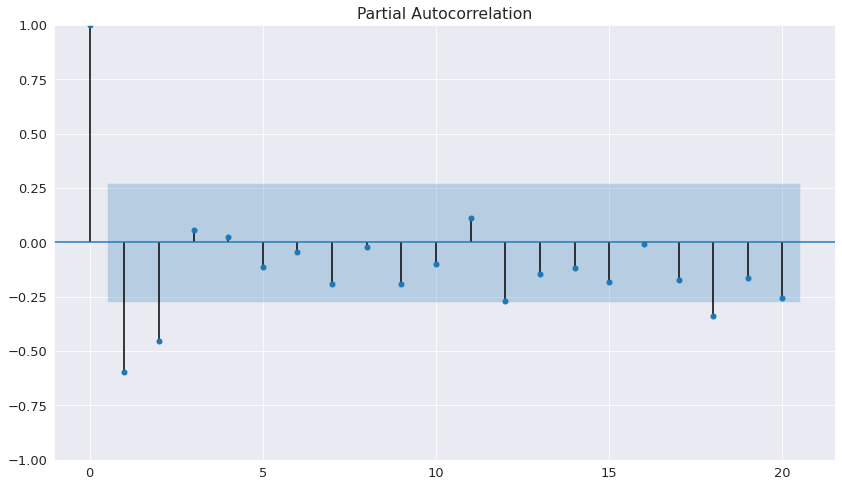

In [40]:
#plotting acf and pacf

fig1 = sm.graphics.tsa.plot_acf(df_diff2,lags=20)
fig2 = sm.graphics.tsa.plot_pacf(df_diff2,lags=20)

**Observations**
- From PACF plot we can say that p=2 as after lag 2nd most for the lags are not significant
- From ACF plot q=1 as as after 1st lag other lags are not that significant
- d value would be 1 as we have differenced once to make the series stationary
- In SARIMA model P,D,Q,s =0 as no seasonality present in the series

In [41]:
# Applying ARIMA
my_model = sm.tsa.arima.ARIMA(train, order=(2,2,1), seasonal_order=(0,0,0,0))
my_model_res = my_model.fit()
print(my_model_res.summary())

                               SARIMAX Results                                
Dep. Variable:                    BTU   No. Observations:                   53
Model:                 ARIMA(2, 2, 1)   Log Likelihood                -574.823
Date:                Sun, 20 Nov 2022   AIC                           1157.646
Time:                        19:36:35   BIC                           1165.374
Sample:                             0   HQIC                          1160.599
                                 - 53                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1677      0.266     -4.393      0.000      -1.689      -0.647
ar.L2         -0.7000      0.182     -3.853      0.000      -1.056      -0.344
ma.L1          0.2616      0.278      0.941      0.3

we can see that ma.L1 term's  p value > 0.05 which means MA(q) process is not applicable here. But lets check Auto Arima and decide  

- also if we see carefully, there is geometric decay in PACF plot and sudden change in ACF which also suggests that the process is AR(p)

In [42]:
pred_no=test.shape[0]
pred_no

6

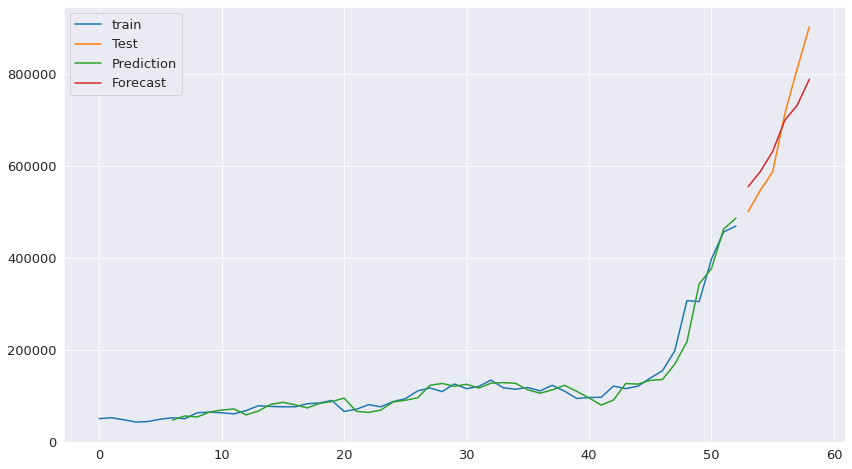

In [43]:
#predicting and forecast on train and test data

tspredict= my_model_res.predict(pred_no)

tsforecast=my_model_res.forecast(pred_no)

plt.plot(train,label='train')
plt.plot(test,label='Test')
plt.plot(tspredict,label='Prediction')
plt.plot(tsforecast,label='Forecast')
plt.legend()

- The predictions are quite good.
- Forecast is a sharp upward trend which shows continuation of the recent trend

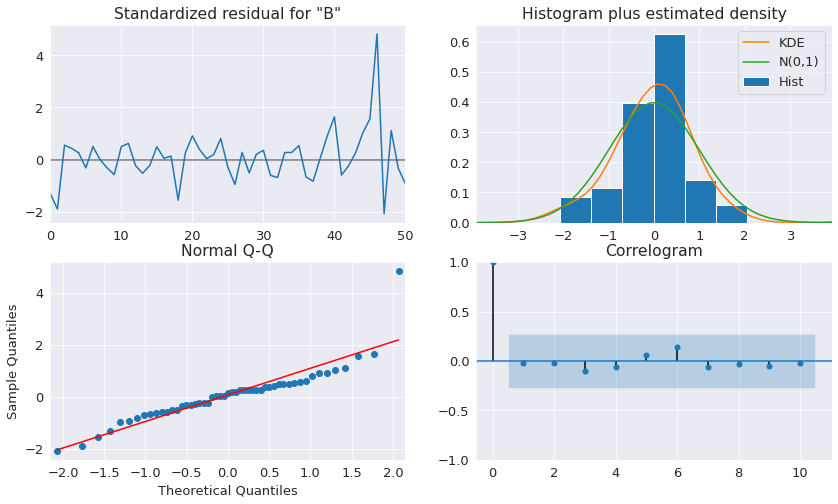

In [44]:
pred = my_model_res.plot_diagnostics()

### Observations

- The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself and hence their mean is zero.

- The KDE plot of the residuals on the top right shows a kind of similar plot as a normal distribution.

- From the normal Q-Q plot, one can infer that we almost have a straight line, which suggests no systematic departure from normality. 



Evaluation metrics-rmse

In [45]:
from sklearn.metrics import mean_squared_error

In [46]:
test.shape

(6,)

In [47]:
rmse = mean_squared_error(test, tsforecast, squared=False)
rmse

66025.58793679204

In [48]:
tsforecast.describe()

count         6.000000
mean     665891.895652
std       89625.269795
min      554992.567860
25%      598983.454829
50%      665724.021637
75%      723890.670618
max      788894.609936
Name: predicted_mean, dtype: float64

# **Auto-Arima**

In [49]:
from pmdarima import auto_arima

In [50]:
arima_model = auto_arima(train,start_p=0, d=1, start_q=0,max_p=5, max_d=5, max_q=5,
                        error_action="ignore",trace = True,
                         suppress_warnings=True,stepwise = True,
                         random_state=20,n_fits= 50 )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1195.503, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1193.859, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1195.478, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1199.598, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1190.166, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1183.463, Time=0.08 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1183.337, Time=0.07 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1185.279, Time=0.09 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1185.271, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1183.676, Time=0.09 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=1187.222, Time=0.13 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1182.143, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=1181.741, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1189.660, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0]          

In [51]:
print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   53
Model:               SARIMAX(3, 1, 0)   Log Likelihood                -586.871
Date:                Sun, 20 Nov 2022   AIC                           1181.741
Time:                        19:43:55   BIC                           1189.546
Sample:                             0   HQIC                          1184.733
                                 - 53                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0162      0.082     -0.197      0.844      -0.177       0.145
ar.L2          0.3312      0.097      3.398      0.001       0.140       0.522
ar.L3          0.4953      0.164      3.017      0.0

## Forecasting using Auto ARIMA

In [52]:
forecast =pd.DataFrame(arima_model.predict(n_periods=pred_no),columns=['forecast'],index=test.index)
forecast

,forecast
53,534456.321939
54,567004.998307
55,594432.679037
56,637052.588677
57,661570.384800
58,688876.028610


In [53]:
forecast_df =pd.DataFrame(arima_model.predict(n_periods=12),columns=['forecast'],index=test.index)
forecast_df=pd.concat([forecast, test],axis=1)
forecast_df

,forecast,BTU
53,534456.321939,500601
54,567004.998307,547503
55,594432.679037,586962
56,637052.588677,714190
57,661570.384800,811457
58,688876.028610,903003


In [54]:
forecast_df.describe()

,forecast,BTU
count,6.000000,6.000000
mean,613898.833562,677286.000000
std,58854.615045,159079.582496
min,534456.321939,500601.000000
25%,573861.918489,557367.750000
50%,615742.633857,650576.000000
75%,655440.935769,787140.250000
max,688876.028610,903003.000000


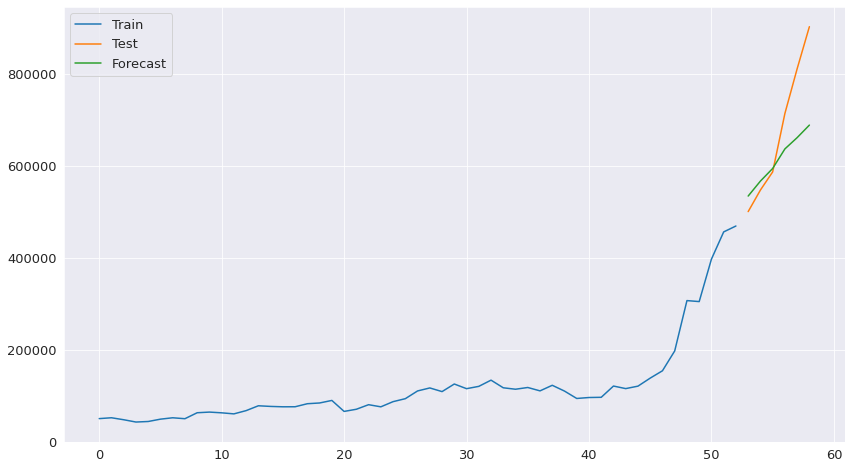

In [55]:
#plotting the graph

plt.plot(train,label='Train')
plt.plot(test,label='Test')
plt.plot(forecast,label='Forecast')
#plt.plot(tsforecast,label='Forecast')
plt.legend()

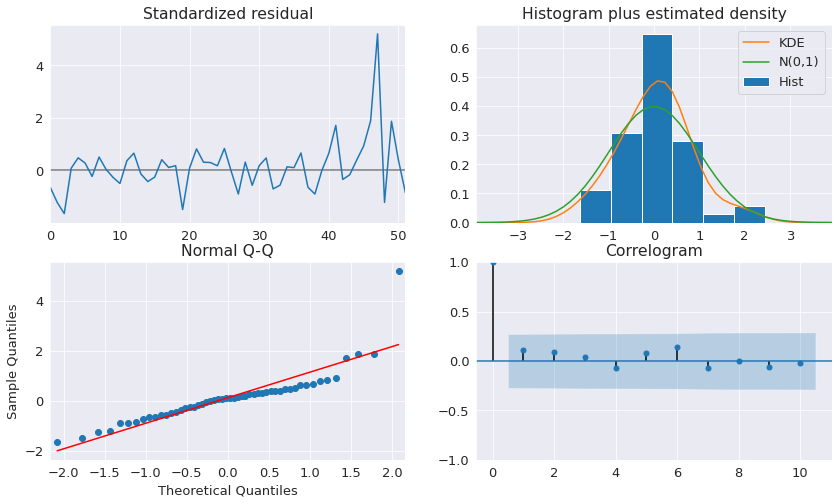

In [56]:
#plotting diagnostics

d= arima_model.plot_diagnostics()

In [57]:
rms = np.sqrt(mean_squared_error(test,forecast_df['forecast'])) # same as squared=False
print('Rmse value:',rms) 

Rmse value: 112434.32106874623


- Rmse of Auto Arima model(1,12,434) is slightly higher than that of manual Arima(66,025)
- This means manual ARIMA is outperforms AUTO-ARIMA in this case 

# **Holt-Winter**

In [58]:
from statsmodels.tsa.holtwinters import Holt # since we only have trend in our data we will apply Holt's model

In [59]:
model = Holt(train)
result = model.fit()
result.params

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


{'smoothing_level': 0.6414285714285713,
 'smoothing_trend': 0.6225630252100839,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 50155.0,
 'initial_trend': 1868.0,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [60]:
print(result.summary())

                              Holt Model Results                              
Dep. Variable:                    BTU   No. Observations:                   53
Model:                           Holt   SSE                    19483476384.940
Optimized:                       True   AIC                           1053.295
Trend:                       Additive   BIC                           1061.176
Seasonal:                        None   AICC                          1055.121
Seasonal Periods:                None   Date:                 Sun, 20 Nov 2022
Box-Cox:                        False   Time:                         19:47:19
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.6414286                alpha                 True
smoothing_trend            0.6225630                

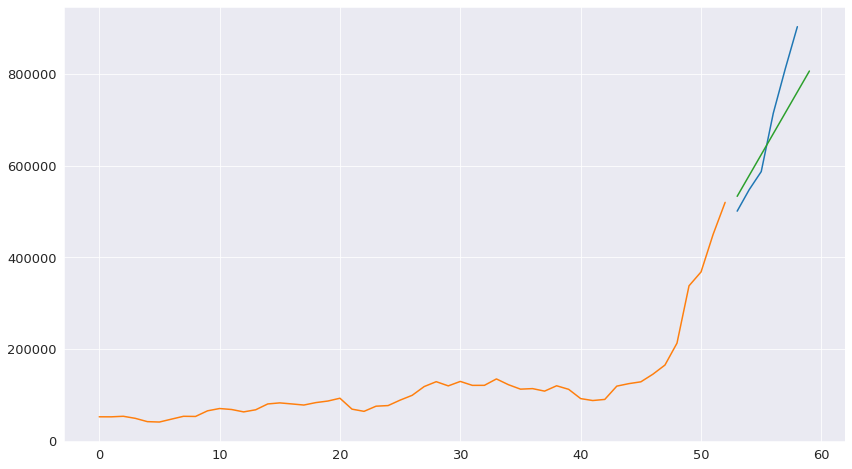

In [78]:
plt.plot(test)
plt.plot(result.fittedvalues)
plt.plot(result.forecast(7))

In [79]:
rmse = mean_squared_error(test, result.forecast(pred_no), squared=False)
rmse

76262.19378038128

- As rmse value of holt model is 76,262 which is greater than rmse value of manual ARIMA(66,025) Model, therefore we can say that for this scenario ARIMA model fits better 

- lets check Holt-winter model as well 

In [63]:
# Exponential Smoothing

In [64]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

trend=mul, season=add

In [87]:
model = ExponentialSmoothing(train, trend='mul', seasonal='add', seasonal_periods=12)

In [88]:
result3 = model.fit()
result3.params

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


{'smoothing_level': 0.8182142857142858,
 'smoothing_trend': 0.15734890109890112,
 'smoothing_seasonal': 0.0001,
 'damping_trend': nan,
 'initial_level': 51163.31666666666,
 'initial_trend': 1.0475739616828332,
 'initial_seasons': array([-2615.44675926,  5229.31712963,  4456.27546296,  -824.94675926,
        -5055.8912037 ,  -365.7662037 ,  2501.71990741,  3530.62268519,
         2555.16435185, -2526.6412037 , -2227.96064815, -4656.44675926]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

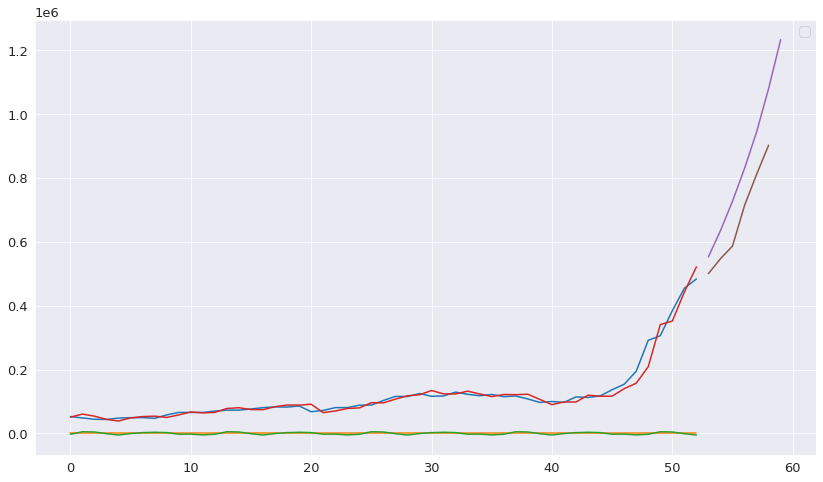

In [89]:
plt.plot(result3.level)
plt.plot(result3.trend)
plt.plot(result3.season)
plt.plot(result3.fittedvalues) #learning part 
plt.plot(result3.forecast(7))
plt.plot(test)
plt.legend()

In [90]:
print(result3.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                      BTU   No. Observations:                   53
Model:             ExponentialSmoothing   SSE                    21736932613.302
Optimized:                         True   AIC                           1083.095
Trend:                   Multiplicative   BIC                           1114.620
Seasonal:                      Additive   AICC                          1103.213
Seasonal Periods:                    12   Date:                 Sun, 20 Nov 2022
Box-Cox:                          False   Time:                         19:50:14
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.8182143                alpha                 True
smoothing_trend          

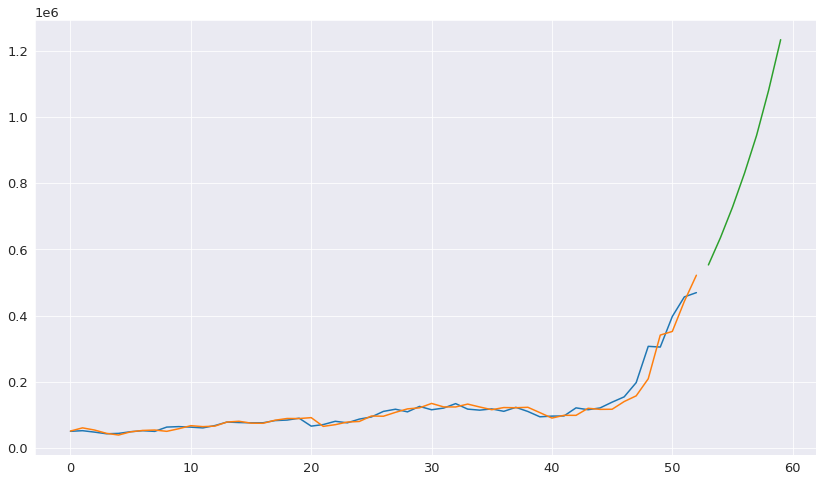

In [91]:
plt.plot(train)
plt.plot(result3.fittedvalues)
plt.plot(result3.forecast(7))

In [92]:
rmse = mean_squared_error(test, result3.forecast(pred_no), squared=False)
rmse

124442.31570267054

additive model

In [93]:
model2 = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12)

In [94]:
result4 = model2.fit()
result4.params

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


{'smoothing_level': 0.6060714285714286,
 'smoothing_trend': 0.6060714285714286,
 'smoothing_seasonal': 0.0001,
 'damping_trend': nan,
 'initial_level': 51163.31666666666,
 'initial_trend': 2434.041666666668,
 'initial_seasons': array([-2615.44675926,  5229.31712963,  4456.27546296,  -824.94675926,
        -5055.8912037 ,  -365.7662037 ,  2501.71990741,  3530.62268519,
         2555.16435185, -2526.6412037 , -2227.96064815, -4656.44675926]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [95]:
print(result4.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                      BTU   No. Observations:                   53
Model:             ExponentialSmoothing   SSE                    18211430028.783
Optimized:                         True   AIC                           1073.716
Trend:                         Additive   BIC                           1105.241
Seasonal:                      Additive   AICC                          1093.834
Seasonal Periods:                    12   Date:                 Sun, 20 Nov 2022
Box-Cox:                          False   Time:                         19:50:36
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.6060714                alpha                 True
smoothing_trend          

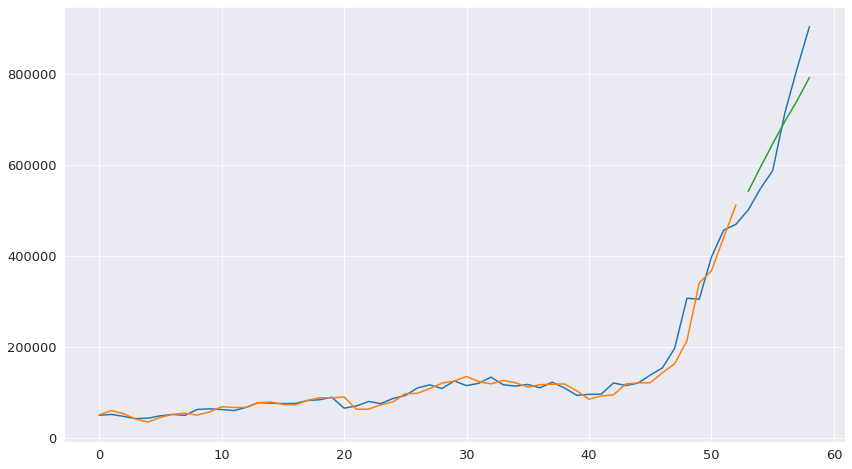

In [98]:
plt.plot(df)
plt.plot(result4.fittedvalues)
plt.plot(result4.forecast(6))

In [97]:
rmse = mean_squared_error(test, result4.forecast(pred_no), squared=False)
rmse

64708.74132026755

- so we can conclude that holt-Winter model with additive trend and additive seasonality gives us the best model among others, as it gives is rmse value of 64,708 as compared to manual SARIMA model which previously gave us rsme value of 66,025

trend add and season mul

In [105]:
model3 = ExponentialSmoothing(train, trend='add', seasonal='mul', seasonal_periods=12)

In [106]:
result5 = model2.fit()
result5.params

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


{'smoothing_level': 0.6060714285714286,
 'smoothing_trend': 0.6060714285714286,
 'smoothing_seasonal': 0.0001,
 'damping_trend': nan,
 'initial_level': 51163.31666666666,
 'initial_trend': 2434.041666666668,
 'initial_seasons': array([-2615.44675926,  5229.31712963,  4456.27546296,  -824.94675926,
        -5055.8912037 ,  -365.7662037 ,  2501.71990741,  3530.62268519,
         2555.16435185, -2526.6412037 , -2227.96064815, -4656.44675926]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [107]:
print(result5.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                      BTU   No. Observations:                   53
Model:             ExponentialSmoothing   SSE                    18211430028.783
Optimized:                         True   AIC                           1073.716
Trend:                         Additive   BIC                           1105.241
Seasonal:                      Additive   AICC                          1093.834
Seasonal Periods:                    12   Date:                 Sun, 20 Nov 2022
Box-Cox:                          False   Time:                         19:54:07
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.6060714                alpha                 True
smoothing_trend          

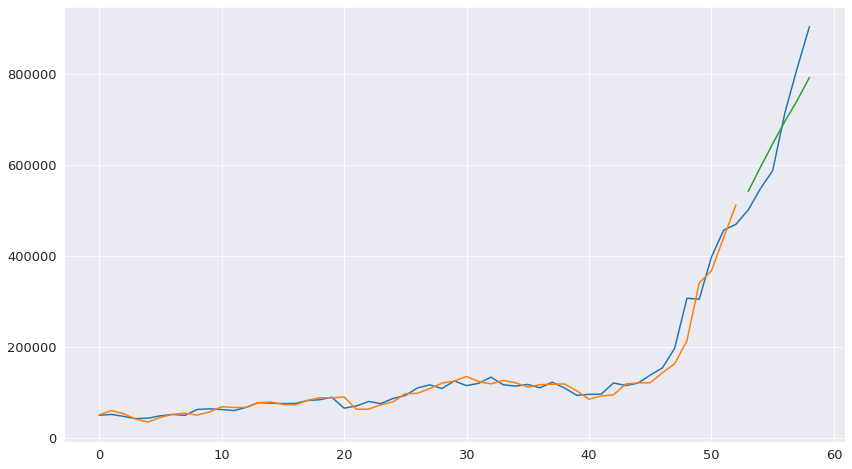

In [108]:
plt.plot(df)
plt.plot(result5.fittedvalues)
plt.plot(result5.forecast(6))

In [109]:
rmse = mean_squared_error(test, result5.forecast(pred_no), squared=False)
rmse

64708.74132026755

same result as that of additive model